# Advanced Machine Learning Homework 1
by Vyacheslav Yastrebov, MADE-ML-22

### 1. Load data

In [1]:
!wget https://github.com/owid/covid-19-data/raw/master/public/data/owid-covid-data.csv
DATA_PATH = 'owid-covid-data.csv'

--2022-03-07 20:49:22--  https://github.com/owid/covid-19-data/raw/master/public/data/owid-covid-data.csv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv [following]
--2022-03-07 20:49:22--  https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47479300 (45M) [text/plain]
Saving to: ‘owid-covid-data.csv.3’

owid-covid-data.csv 100%[===================>]  45.28M   239MB/s    in 0.2s    

2022-03-07 20:49:23 (239 MB/s) - ‘owid-covid-data.csv.3’ saved [4747

In [2]:
from datetime import datetime, timedelta

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.metrics import mean_squared_error

In [3]:
BEGINNING_DATE = datetime(2020, 3, 3)

covid_data_df = pd.read_csv(DATA_PATH)

russia_covid_data_df = covid_data_df[covid_data_df['location'] == 'Russia']
russia_covid_data_df['date'] = pd.to_datetime(russia_covid_data_df['date'], format='%Y-%m-%d')
russia_covid_data_df = russia_covid_data_df[russia_covid_data_df['date'] >= BEGINNING_DATE]
russia_covid_data_df['new_cases'] = russia_covid_data_df['new_cases'].replace(0, 1)
russia_covid_data_df['total_cases'] = russia_covid_data_df['total_cases'].replace(0, 1)
russia_covid_data_df.sort_values('date', inplace=True)
russia_covid_data_df.index = range(len(russia_covid_data_df.index))
russia_covid_data_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,RUS,Europe,Russia,2020-03-03,3.0,1.0,0.143,NaN,NaN,NaN,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
1,RUS,Europe,Russia,2020-03-04,3.0,1.0,0.143,NaN,NaN,NaN,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
2,RUS,Europe,Russia,2020-03-05,4.0,1.0,0.286,NaN,NaN,NaN,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
3,RUS,Europe,Russia,2020-03-06,13.0,9.0,1.571,NaN,NaN,NaN,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
4,RUS,Europe,Russia,2020-03-07,13.0,1.0,1.571,NaN,NaN,NaN,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN


In [4]:
TRAIN_DATA_END_DATE = BEGINNING_DATE + timedelta(days=50)
train_covid_data_df = russia_covid_data_df[(russia_covid_data_df['date'] >= BEGINNING_DATE) & (russia_covid_data_df['date'] < TRAIN_DATA_END_DATE)]
test_covid_data_df = russia_covid_data_df[russia_covid_data_df['date'] >= TRAIN_DATA_END_DATE]

### 2. Plot 

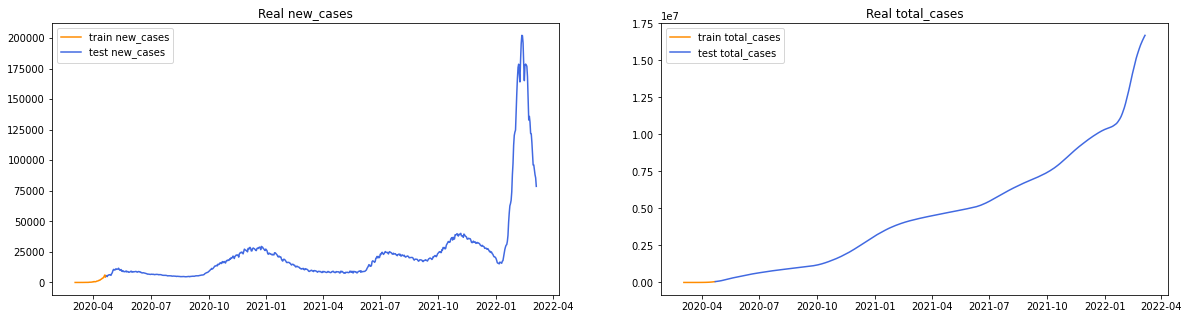

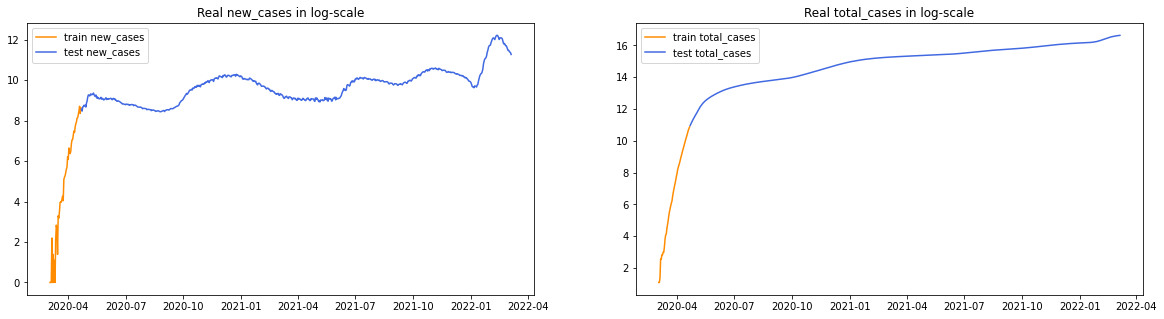

In [5]:
def plot_data(train_df, test_df, log, title_prefix):
  plt.rcParams["figure.figsize"] = (20, 5)
  fig, ax = plt.subplots(1, 2)
  for i, target in enumerate(['new_cases', 'total_cases']): 
    title = f'{title_prefix} {target}'
    train_y, test_y = train_df[target], test_df[target]
    if log:
      title = f'{title} in log-scale'
      train_y, test_y = np.log(train_y), np.log(test_y)
    ax[i].set_title(title)
    ax[i].plot(train_df['date'], train_y, label=f'train {target}', color=mcolors.CSS4_COLORS['darkorange'])
    ax[i].plot(test_df['date'], test_y, label=f'test {target}', color=mcolors.CSS4_COLORS['royalblue'])
    ax[i].legend()

plot_data(train_covid_data_df, test_covid_data_df, False, 'Real')
plot_data(train_covid_data_df, test_covid_data_df, True, 'Real')

### 2.a Linear Regression

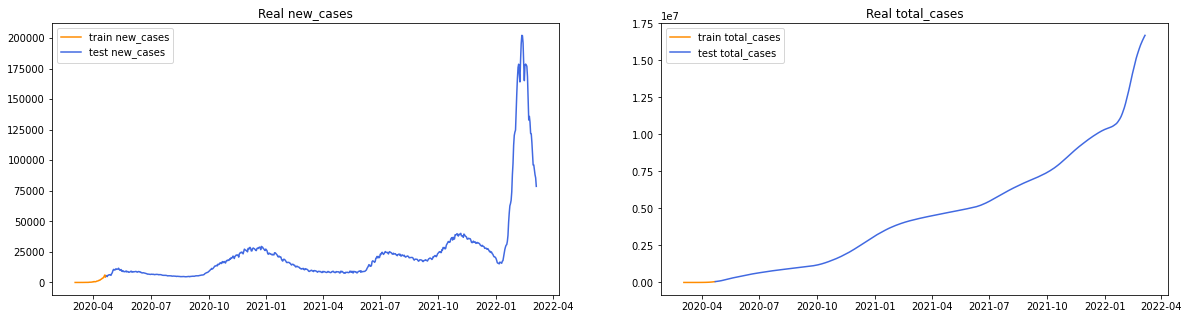

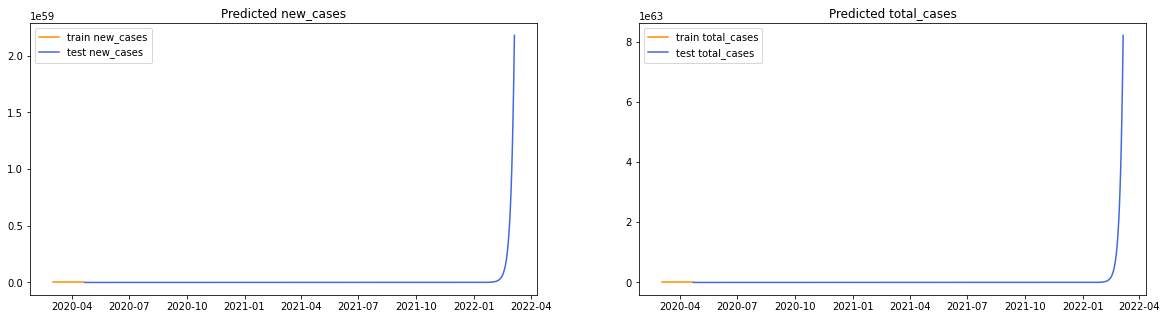

In [6]:
from sklearn.linear_model import LinearRegression


def train_linear_regression(train_df, variable):
    train_x = [[day] for day in train_df.index.values]
    train_y = np.log(train_df[variable].to_numpy())
    model = LinearRegression()
    model.fit(train_x, train_y)
    return model

def generate_df_with_predictions(model, test_df, variable):
    test_x = [[day] for day in test_df.index.values]
    predicted_y = model.predict(test_x)
    predicted_df = test_df.copy()
    predicted_df[variable] = np.exp(predicted_y)
    return predicted_df

new_cases_model = train_linear_regression(train_covid_data_df, 'new_cases')
total_cases_model = train_linear_regression(train_covid_data_df, 'total_cases')
predicted_train_df = generate_df_with_predictions(new_cases_model, train_covid_data_df, 'new_cases')
predicted_train_df = generate_df_with_predictions(new_cases_model, predicted_train_df, 'total_cases')
predicted_test_df = generate_df_with_predictions(new_cases_model, test_covid_data_df, 'new_cases')
predicted_test_df = generate_df_with_predictions(total_cases_model, predicted_test_df, 'total_cases')
plot_data(train_covid_data_df, test_covid_data_df, False, 'Real')
plot_data(predicted_train_df, predicted_test_df, False, 'Predicted')

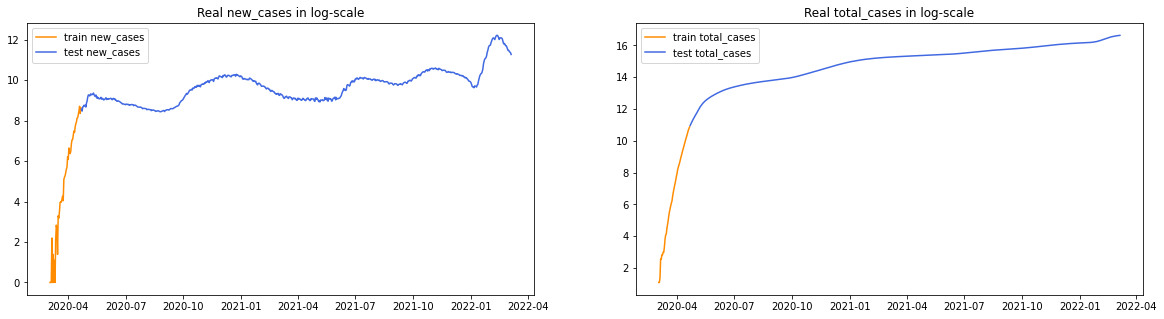

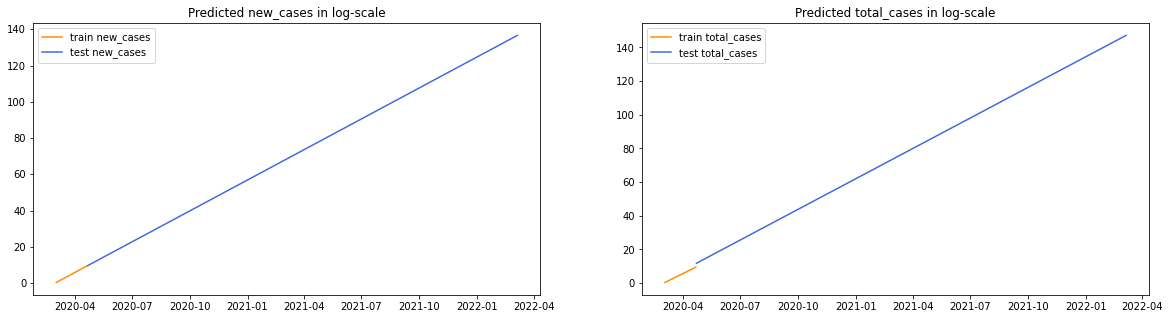

In [7]:
plot_data(train_covid_data_df, test_covid_data_df, True, 'Real')
plot_data(predicted_train_df, predicted_test_df, True, 'Predicted')

### 2.b Posteriori parameters distribution

In [8]:
def bayesian_update(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = np.array([[1, x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y])))
    return mu_n, sigma_n

In [9]:
def calculate_params(model, df, target):
    mu, sigma = np.array([0, 0]), 30 * np.array([[1, 0], [0, 1]])
    true_values = np.log(df[target].values)
    days = [[day] for day in df.index.values]
    predicted_values = model.predict(days)
    mse = mean_squared_error(true_values, predicted_values)
    for [day] in days:
        mu, sigma = bayesian_update(mu, sigma, day, true_values[day], mse)
    return mu, sigma

In [10]:
def plot_heatmap(X, Y, Z):
    plt.rcParams["figure.figsize"] = (20, 5)
    plt.axis('equal')
    plt.xlim((-10, 10))
    plt.ylim((-1, 1))
    plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
    plt.title('Posterior distribution')

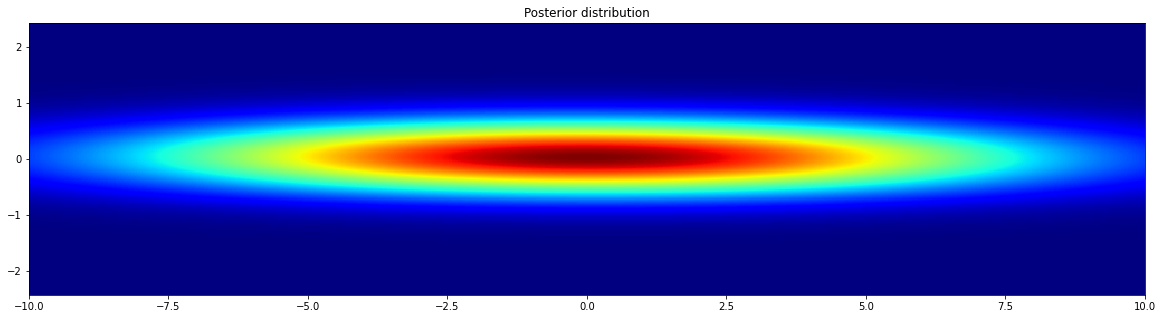

In [11]:
mu, sigma = calculate_params(total_cases_model, russia_covid_data_df, 'total_cases')

N = 1000

X = np.linspace(mu[0] - 10, mu[0] + 10, N)
Y = np.linspace(mu[1] - 10, mu[1] + 10, N)
X, Y = np.meshgrid(X, Y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y
Z = multivariate_normal.pdf(pos, mean=mu, cov=sigma)
plot_heatmap(X, Y, Z)


### 2.c Sample multiple exponents. How many infection cases will be detected by May, 1; June, 1; September, 1
 

In [16]:
def plot_sample_exponents(df, model, mu, sigma, n=50):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    days = [[day] for day in df.index.values]
    xs = df.index.values
    ys = np.exp(model.predict(days))
    plt.plot(xs, ys, 'k-', lw=.4, color=mcolors.CSS4_COLORS['orange'])
    for w in my_w:
        plt.plot(xs, np.exp(w[0] + w[1] * xs), 'k-', lw=.4)
    plt.xlim((0, 50))
    plt.ylim((0, df['total_cases'].iloc[-1]))

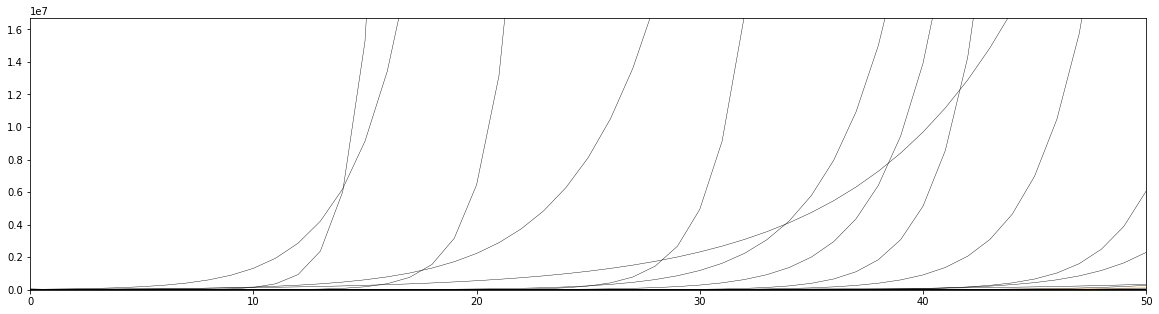

In [17]:
plot_sample_exponents(russia_covid_data_df, total_cases_model, mu, sigma)

In [18]:
def get_prediction(mu, sigma, day, n=50):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    preds = np.zeros(n)
    for i, w in enumerate(my_w):
      preds[i] = np.exp(w[0] + w[1] * day)
    return np.mean(preds)

In [19]:
# Let's check for 2021, since for 2022 there is overflow :)

days = {
  'May, 1': (datetime(2021, 5, 1) - BEGINNING_DATE).days,
  'June, 1': (datetime(2021, 6, 1) - BEGINNING_DATE).days,
  'September, 1': (datetime(2021, 9, 1) - BEGINNING_DATE).days
}

for date, day_index in days.items():
  predictions = get_prediction(mu, sigma, day_index)
  print(f'{predictions} infections are expected by {date}')

7.267876225186131e+176 infections are expected by May, 1
7.822161040627635e+140 infections are expected by June, 1
4.843607673614956e+271 infections are expected by September, 1
